# LFRic-Atmosphere's C48 cubed-sphere mesh shown using illustrative snapshots at the end of one of the THAI Hab 1 simulations

## Import libraries

Standard library

In [1]:
from functools import partial
from typing import Callable, Optional, Sequence, Union

External modules

In [2]:
import cartopy.crs as ccrs
import iris
import numpy as np
from aeolus.calc import wind_speed
from aeolus.model import lfric
from aeolus.subset import DimConstr

GeoVista and PyVista

In [3]:
import geovista as gv
import geovista.theme
import pyvista as pv

pv.global_theme.trame.server_proxy_enabled = True

pv.set_jupyter_backend("client")

Local modules

In [4]:
import paths
from lfric_util import add_um_height_coord, load_lfric_raw

Print out system info & key libraries

In [5]:
import scooby

scooby.doo(
    core=sorted(["aeolus", "geovista", "iris", "cartopy", "pyvista"]),
    optional=[],
    ncol=1,
)

--------------------------------------------------------------------------------
  Date: Wed Apr 05 13:30:58 2023 UTC

                OS : Linux
            CPU(s) : 192
           Machine : x86_64
      Architecture : 64bit
               RAM : 503.5 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.11.2 | packaged by conda-forge | (main, Mar 31 2023, 17:51:05) [GCC
  11.3.0]

            aeolus : 0.4.16+16.g7a995fd
           cartopy : 0.21.1
          geovista : 0.1.4
              iris : 3.4.1
           pyvista : 0.38.5
--------------------------------------------------------------------------------

## Load raw LFRic-Atmosphere data

Define file paths

In [6]:
inpdir = paths.results_raw_lfric / "thai_hab1"
c_num = 48
fnames = sorted(
    inpdir.glob(f"*/*{c_num}*/lfric_diag.nc"),
    key=lambda x: int(x.parent.parent.name),
)

Create a function to add vertical levels info

In [7]:
add_levs = partial(
    add_um_height_coord,
    path_to_levels_file=paths.vert / "vertlevs_L38_29t_9s_40km",
)

Load only the last file and attach vertical levels via an iris callback

In [8]:
cl = load_lfric_raw(fnames[-1], callback=add_levs)

Print available cubes

In [9]:
DC = DimConstr(model=lfric)
for cube in cl.extract(DC.relax.t):
    print(f"{cube.var_name}")

temperature
tot_col_m_ci
tot_col_m_cl
tot_col_m_v
cloud_amount_maxrnd
u_in_w3
grid_surface_temperature
v_in_w3
pressure_in_wth
lw_down_surf
sw_down_surf
lw_up_surf
sw_up_surf
sw_direct_toa
lw_up_clear_toa_rts
sw_up_clear_toa_rts
lw_up_toa
sw_up_toa
w_in_wth


## Process data by converting iris cubes into geovista meshes

Define a function to convert 2D cubes to a `geovista` mesh

In [10]:
def cube2d_to_mesh(
    cube2d: iris.cube.Cube,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    **kwargs
) -> pv.PolyData:
    """Construct a spherical mesh from a 2D iris cube using geovista."""
    data = cube2d.data
    if vmin is None and vmax is None:
        data = data.copy()
    elif vmin is None and vmax is not None:
        data = np.ma.masked_greater(data, vmax)
    elif vmin is not None and vmax is None:
        data = np.ma.masked_less(data, vmin)
    else:
        data = np.ma.masked_outside(data, vmin, vmax)
    mesh = gv.Transform.from_unstructured(
        *[i.points for i in cube2d.mesh.node_coords],
        cube2d.mesh.face_node_connectivity.indices_by_location(),
        data=data,
        start_index=cube2d.mesh.face_node_connectivity.start_index,
        **kwargs
    )
    return mesh

Select variables and the time slice (`t_idx`)

In [11]:
t_idx = -2

t_sfc = cl.extract_cube("grid_surface_temperature")[t_idx, ...]
u = cl.extract_cube("u_in_w3")[t_idx, ...]
u.units = "m s-1"
v = cl.extract_cube("v_in_w3")[t_idx, ...]
v.units = "m s-1"
wspd = wind_speed(u, v)

# cloud_amount_maxrnd = cl.extract_cube("cloud_amount_maxrnd")[t_idx, ...]
# tot_col_m_ci = cl.extract_cube("tot_col_m_ci")[t_idx, ...]
# tot_col_m_cl = cl.extract_cube("tot_col_m_cl")[t_idx, ...]
# tot_col_m_v = cl.extract_cube("tot_col_m_v")[t_idx, ...]
# tot_col_m_ci_mesh = cube2d_to_mesh(tot_col_m_ci)
# tot_col_m_cl_mesh = cube2d_to_mesh(tot_col_m_cl)
# tot_col_m_v_mesh = cube2d_to_mesh(tot_col_m_v)
# cloud_amount_maxrnd_mesh = cube2d_to_mesh(cloud_amount_maxrnd)

Convert variables into separate meshes

In [12]:
t_sfc_mesh = cube2d_to_mesh(t_sfc, name=t_sfc.var_name)

wspd_mesh = cube2d_to_mesh(wspd[22, ...], name=wspd.name())  # , vmin=30, radius=1.0)

## Assemble the figure

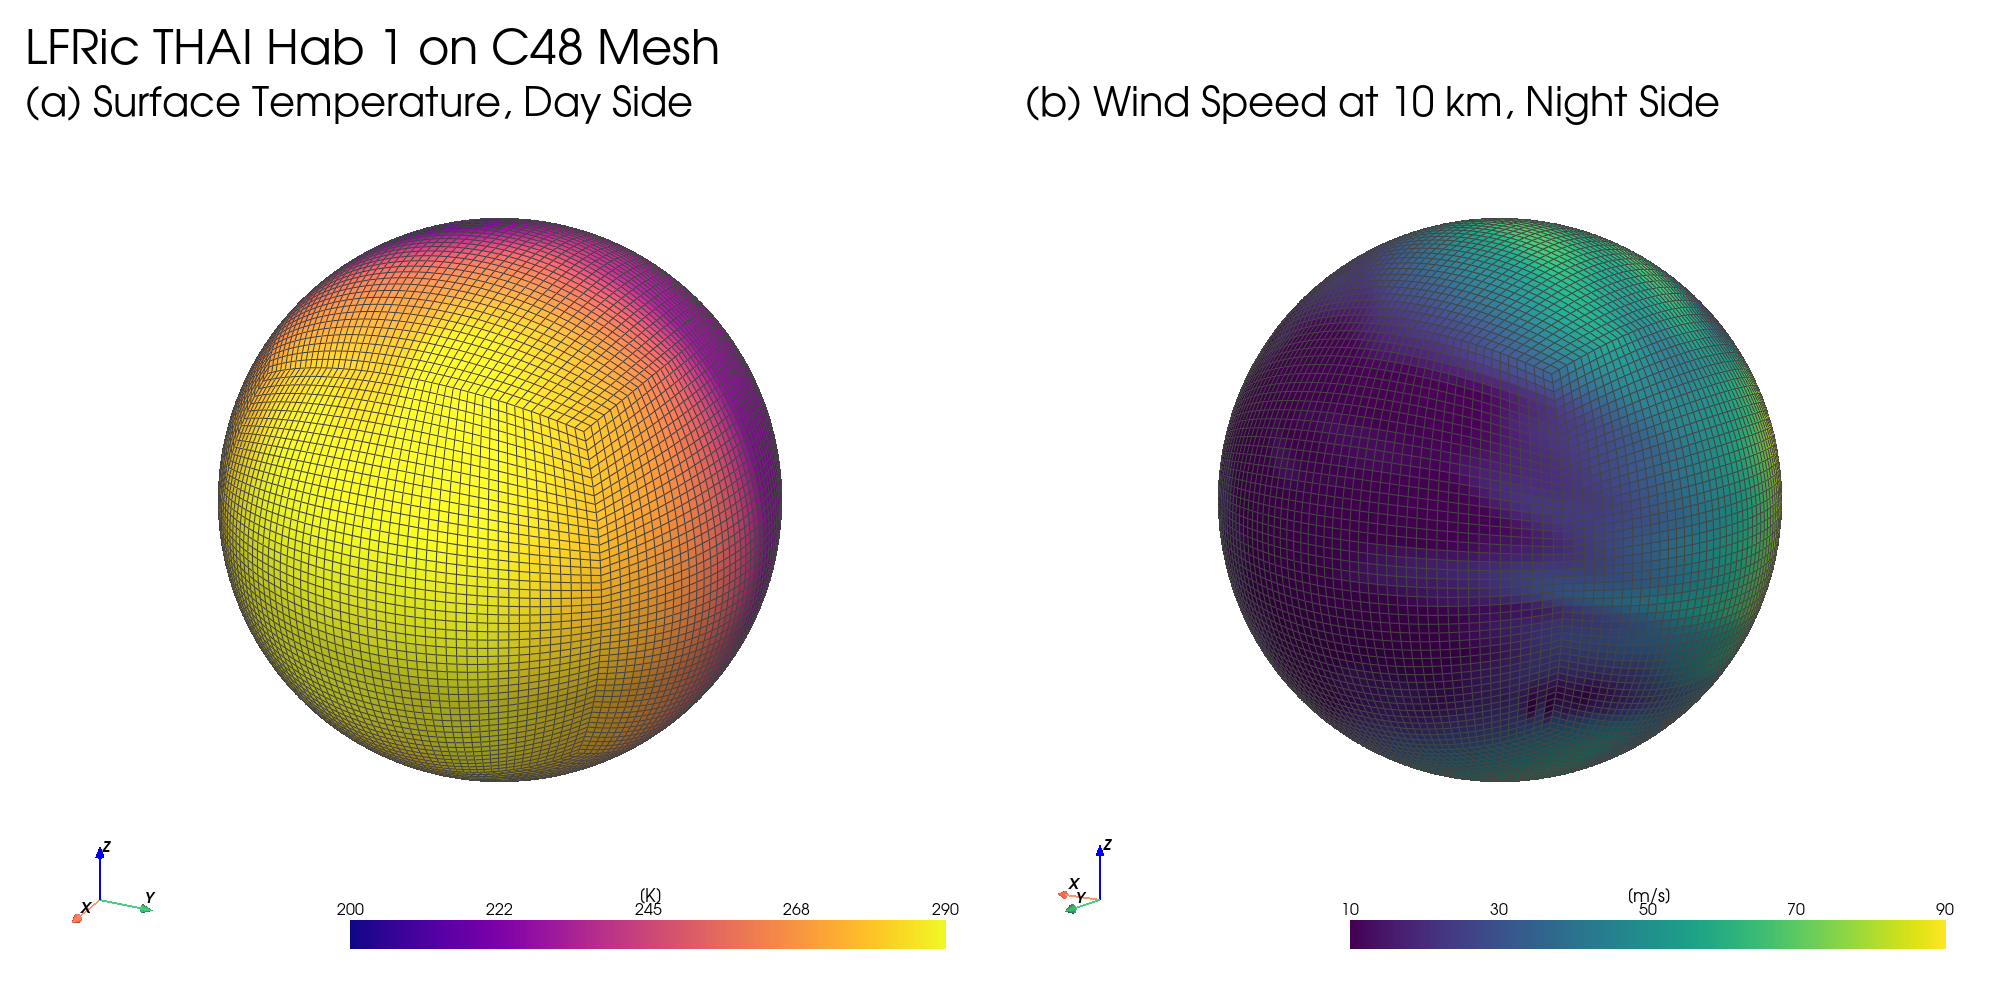

In [13]:
plotter = gv.GeoPlotter(window_size=[2000, 1000], shape=(1, 2), border=False)
# plotter.add_mesh(
#     w_mesh,
#     show_scalar_bar=True,
#     # cmap="coolwarm",
#     # clim=[-0.1, 0.1],
#     # show_edges=True,
#     edge_color="#444444",
#     lighting=True,
#     # nan_opacity=0,
#     # nan_color="k",
#     # n_colors=10,
# )
light = pv.Light(
    position=(1.75 * np.pi, -1 * np.pi, 2),
    # show_actor=True,
    positional=True,
    cone_angle=20,
    exponent=10,
    intensity=0.15,
)
plotter.add_mesh(
    t_sfc_mesh,
    show_scalar_bar=False,
    cmap="plasma",
    clim=[200, 290],
    show_edges=True,
    edge_color="#444444",
    lighting=True,
    ambient=0.25,
)
plotter.add_scalar_bar(title="[K]", title_font_size=18, label_font_size=16, fmt="%.0f")
plotter.add_axes()
plotter.view_vector((1, 0.5, 0.5))
# plotter.view_xy()
plotter.add_text(
    "(a) Surface Temperature, Day Side",
    position=(0.025, 0.875),
    viewport=True,
    font_size=20,
)
plotter.add_text(
    "LFRic THAI Hab 1 on C48 Mesh", position=(0.025, 0.925), viewport=True, font_size=24
)
plotter.add_light(light)

plotter.subplot(0, 1)
plotter.add_mesh(
    wspd_mesh,
    show_scalar_bar=False,
    cmap="viridis",
    clim=[10, 90],
    show_edges=True,
    edge_color="#444444",
    lighting=True,
    ambient=0.25,
)
plotter.add_axes()
plotter.view_vector((-0.5, 0.75, 0.20))
# plotter.view_xy()
plotter.add_text(
    "(b) Wind Speed at 10 km, Night Side",
    position=(0.025, 0.875),
    viewport=True,
    font_size=20,
)
plotter.add_scalar_bar(
    title="[m/s]", title_font_size=18, label_font_size=16, fmt="%.0f"
)
# plotter.add_light(light)

# plotter.show()
plotter.show(jupyter_backend="static")
plotter.save_graphic(paths.figures / f"thai_hab1___gv__t_sfc_wspd_10km.pdf")

---

## 2D picture (map)

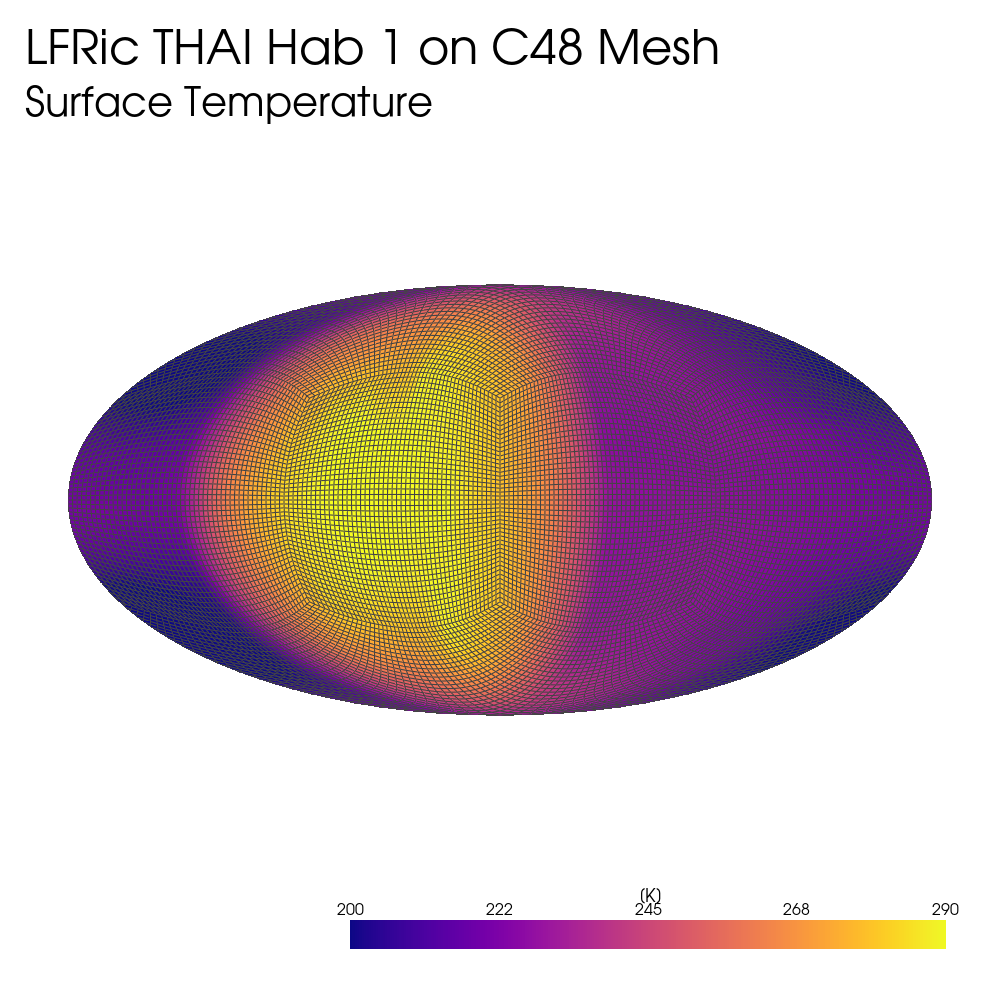

In [14]:
t_sfc_mesh = cube2d_to_mesh(t_sfc, name=t_sfc.var_name)
plotter = gv.GeoPlotter(
    window_size=[1000, 1000],
    crs=ccrs.Mollweide(central_longitude=45),
    border=False,
)
plotter.add_mesh(
    t_sfc_mesh,
    show_scalar_bar=False,
    cmap="plasma",
    clim=[200, 290],
    show_edges=True,
    edge_color="#444444",
    lighting=True,
    ambient=0.25,
)
plotter.add_scalar_bar(title="[K]", title_font_size=18, label_font_size=16, fmt="%.0f")
plotter.view_xy()
plotter.add_text(
    "Surface Temperature",
    position=(0.025, 0.875),
    viewport=True,
    font_size=20,
)
plotter.add_text(
    "LFRic THAI Hab 1 on C48 Mesh", position=(0.025, 0.925), viewport=True, font_size=24
)

plotter.show(jupyter_backend="static")